# Sentiment Classification Model Using ViT

Our goal is to run 40,000 FFHQ-512 images on a pre-trained emotion detection image classifier, store and label the predictions, and preform
attacks on the data.

In [7]:
import torch.nn as nn
import torch.optim as optim
import torch
import torchvision.models as models
from torchattacks.attack import Attack
import torchvision.transforms as transforms
from torchattacks import JSMA, PGD, FGSM, SPSA, RFGSM, Jitter, OnePixel, FAB, AutoAttack
from transformers import AutoImageProcessor, ViTForImageClassification
from PIL import Image
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import art.attacks.evasion as evasion
from art.estimators.classification import PyTorchClassifier

from attacks import Attack
import attackstorch
from transformers import AutoImageProcessor, ViTForImageClassification
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import pandas as pd
import numpy as np
import os
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


### Sample Classification on Image Data Using ViT

Model: https://huggingface.co/RickyIG/emotion_face_image_classification_v3/blob/main/config.json

In [3]:
processor = AutoImageProcessor.from_pretrained("RickyIG/emotion_face_image_classification_v3")
model = ViTForImageClassification.from_pretrained("RickyIG/emotion_face_image_classification_v3")
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

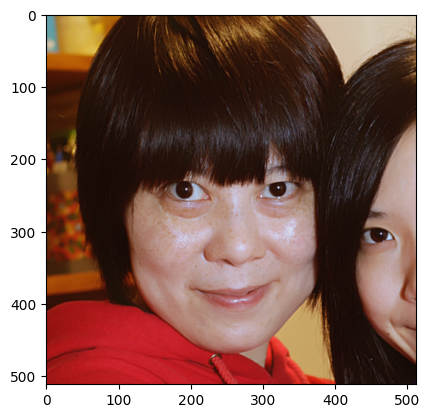

Prediction:  happy
Confidence:  0.296427458524704


In [38]:
# creating a image object (main image)

def get_image_label(filename, show_image=False):
    '''
    Given the filename of the image, return the classified label
    and its logits (logits are used to determine confidence).
    '''
    image = Image.open(rf"{filename}") 
    inputs = processor(image, return_tensors="pt")

    with torch.no_grad():
        logits = model(**inputs).logits

    # model predicts one of the 1000 ImageNet classes
    if show_image:
        img = mpimg.imread(f'{filename}')
        imgplot = plt.imshow(img)
        plt.show()

    predicted_label = logits.argmax(-1).item()

    return model.config.id2label[predicted_label], logits

def get_confidence(logits):
    '''
    Return the confidence value for the associated classification. 
    '''
    min_value = torch.min(logits)
    max_value = torch.max(logits)
    normalized_tensor = (logits - min_value) / (max_value - min_value)
    sum_values = torch.sum(normalized_tensor)

    return torch.max(normalized_tensor / sum_values).item()

label, logits = get_image_label("./FFHQ512/00008.png", show_image=True)
print("Prediction: ", label)
print("Confidence: ", get_confidence(logits))

### Store Labeled Images Into DataFrame

This will run the predictions and store the values into the dataframe, saved into file `FFHQ-512-labeled.csv`:

Keys: image, expression, confidence

In [32]:
# df = pd.DataFrame(columns=['image', 'expression', 'confidence'])
# n_images = 40000

# for num in range(n_images):
#     image_name = f'{num:05d}.png'
#     image_path = f'./FFHQ512/{image_name}'

#     if not os.path.isfile(image_path):
#         print(f"{image_path} does not exist.")
#         continue

#     expression, logits = get_image_label(image_path)
#     confidence = get_confidence(logits)

#     entry = [image_name, expression, confidence]
#     df_entry = pd.DataFrame(entry, index=["image", "expression", "confidence"]).T
#     df = pd.concat((df, df_entry))

# print(df)
# df.to_csv('./FFHQ-512-labeled.csv')  
    

### Running the Attacks
We have automated our attack framework by running specific attack methods on every entry in the `FFHQ-512-labeled.csv` associated images. The output of `run_attack` will be the results of the attack on the `FFHQ-512-labeled.csv` data.

In [ ]:
def run_attack(attack, filename):
    '''
    Given an attack, run the attack on all images in the FFHQ-512-labeled.csv file. This
    will save the attack results into the filename (csv).
    '''
    print("Running Attack...")
    print(f"{filename}")

    orig_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/FFHQ512-Labeled/FFHQ-512-labeled.csv")
    label_encoder = LabelEncoder()
    
    attack_df = pd.DataFrame(columns=['image', 'expression', 'confidence'])
    step = 100
    n_images = 38000

    total_time = time.time()
    end_time = 0
    start_time = 0
    times = []
    # runs the attacks in batches for memory purposes.
    for x in range(0, n_images, step):
        if x != 0:
            times.append(end_time - start_time)
        print(f"Progress: {(x / n_images) * 100:.2f}% Done, Time Elapsed: {(end_time - total_time) / 60:.3f}m, Estimated Total: {(np.mean(np.array(times)) * (n_images / step)) / 60:.3f}m")
        start_time = time.time()
        batch_df = orig_df[x:x+step]
        encoded_labels = label_encoder.fit_transform(batch_df["expression"])
        batch_df["expression"] = encoded_labels

        labels = torch.tensor(batch_df["expression"].values)
        adv_images, file_names = attackstorch.generate_attack(attack, batch_df, labels)

        for i, image in enumerate(adv_images):
            image.save("./FGSM.png")
            expression, logits = get_image_label("./FGSM.png")
            confidence = get_confidence(logits)
            entry = [file_names[i], expression, confidence]
            attack_df_entry = pd.DataFrame(entry, index=["image", "expression", "confidence"]).T
            attack_df = pd.concat((attack_df, attack_df_entry))
            
        end_time = time.time()
    
    attack_df.to_csv(f'./FFHQ512-Labeled/{filename}')

# UNCOMMENT BELOW TO RUN METHOD
# model = models.resnet18(pretrained=True)
# model.to(device)
# PGD_attack1 = PGD(model, eps=0.1, alpha=0.1)
# run_attack(PGD_attack1, 'FFHQ-512-PGD-10-10.csv')

### Data Analysis

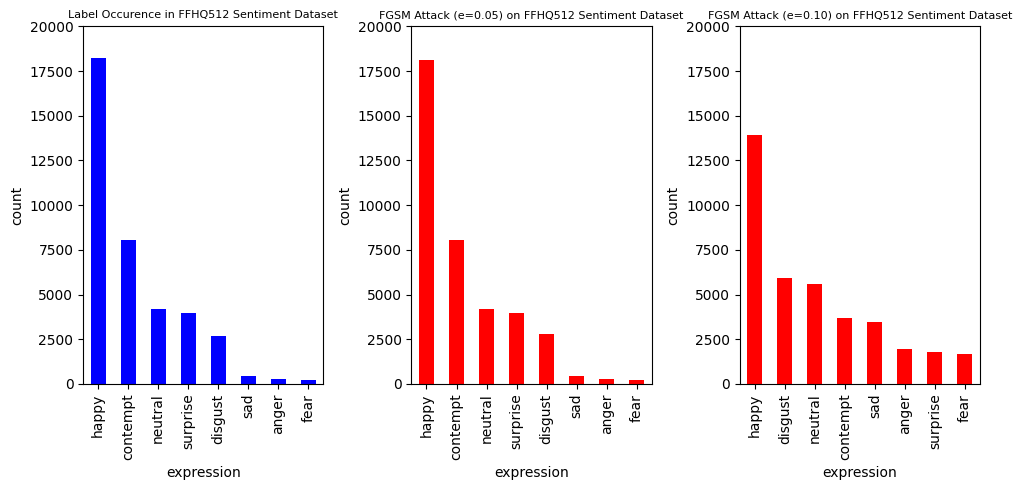

In [13]:
plt.figure(figsize=(10,5))
# xaxis_order = ["happy", "contempt", "surprise", "neutral", "disgust", "sad", "anger", "fear"]
plt.subplot(1, 3, 1)
data = pd.read_csv("./FFHQ512-Labeled/FFHQ-512-labeled.csv")
counts = data["expression"].value_counts()
counts.plot(kind="bar", color="blue")
plt.ylim(0, 20000)
plt.title("Label Occurence in FFHQ512 Sentiment Dataset", fontsize=8)
plt.ylabel("count")

plt.subplot(1, 3, 2)
data_adv = pd.read_csv("./FFHQ512-Labeled/FFHQ-512-FGSM-05.csv")
counts_adv = data_adv["expression"].value_counts()
counts_adv.plot(kind="bar", color="red")
plt.ylim(0, 20000)
plt.title("FGSM Attack (e=0.05) on FFHQ512 Sentiment Dataset", fontsize=8)
plt.ylabel("count")

plt.subplot(1, 3, 3)
data_adv_2 = pd.read_csv("./FFHQ512-Labeled/FFHQ-512-FGSM-10.csv")
counts_adv_2 = data_adv_2["expression"].value_counts()
# sns.barplot(x='expression', data=data_adv_2, order=xaxis_order, color="blue")
counts_adv_2.plot(kind="bar", color="red")
plt.ylim(0, 20000)
plt.title("FGSM Attack (e=0.10) on FFHQ512 Sentiment Dataset", fontsize=8)
plt.ylabel("count")
plt.tight_layout()

### Only FGSM Attacks

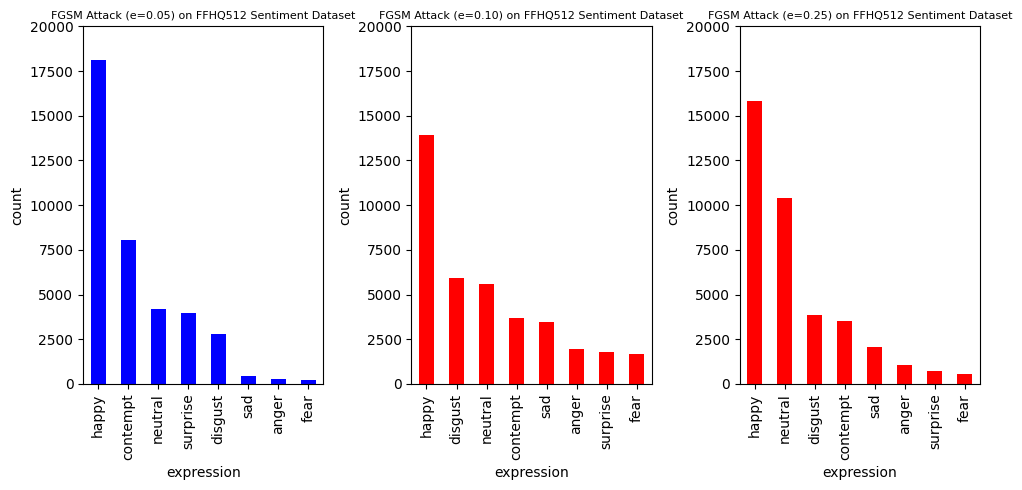

In [14]:
plt.figure(figsize=(10,5))
# xaxis_order = ["happy", "contempt", "surprise", "neutral", "disgust", "sad", "anger", "fear"]
plt.subplot(1, 3, 1)
data = pd.read_csv("./FFHQ512-Labeled/FFHQ-512-FGSM-05.csv")
counts = data["expression"].value_counts()
counts.plot(kind="bar", color="blue")
plt.ylim(0, 20000)
plt.title("FGSM Attack (e=0.05) on FFHQ512 Sentiment Dataset", fontsize=8)
plt.ylabel("count")

plt.subplot(1, 3, 2)
data_adv = pd.read_csv("./FFHQ512-Labeled/FFHQ-512-FGSM-10.csv")
counts_adv = data_adv["expression"].value_counts()
counts_adv.plot(kind="bar", color="red")
plt.ylim(0, 20000)
plt.title("FGSM Attack (e=0.10) on FFHQ512 Sentiment Dataset", fontsize=8)
plt.ylabel("count")

plt.subplot(1, 3, 3)
data_adv_2 = pd.read_csv("./FFHQ512-Labeled/FFHQ-512-FGSM-25.csv")
counts_adv_2 = data_adv_2["expression"].value_counts()
# sns.barplot(x='expression', data=data_adv_2, order=xaxis_order, color="blue")
counts_adv_2.plot(kind="bar", color="red")
plt.ylim(0, 20000)
plt.title("FGSM Attack (e=0.25) on FFHQ512 Sentiment Dataset", fontsize=8)
plt.ylabel("count")
plt.tight_layout()

### Only PGD Attacks

Text(0, 0.5, 'count')

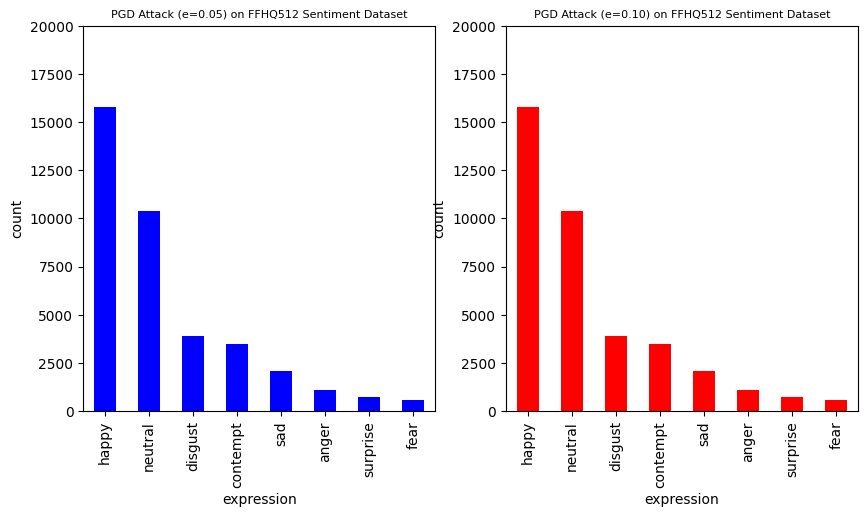

In [15]:
plt.figure(figsize=(10,5))
# xaxis_order = ["happy", "contempt", "surprise", "neutral", "disgust", "sad", "anger", "fear"]
plt.subplot(1, 2, 1)
data = pd.read_csv("./FFHQ512-Labeled/FFHQ-512-PGD-05.csv")
counts = data["expression"].value_counts()
counts.plot(kind="bar", color="blue")
plt.ylim(0, 20000)
plt.title("PGD Attack (e=0.05) on FFHQ512 Sentiment Dataset", fontsize=8)
plt.ylabel("count")

plt.subplot(1, 2, 2)
data_adv = pd.read_csv("./FFHQ512-Labeled/FFHQ-512-PGD-10.csv")
counts_adv = data_adv["expression"].value_counts()
counts_adv.plot(kind="bar", color="red")
plt.ylim(0, 20000)
plt.title("PGD Attack (e=0.10) on FFHQ512 Sentiment Dataset", fontsize=8)
plt.ylabel("count")

# plt.subplot(1, 3, 3)
# data_adv_2 = pd.read_csv("./FFHQ512-Labeled/FFHQ-512-FGSM-25.csv")
# counts_adv_2 = data_adv_2["expression"].value_counts()
# # sns.barplot(x='expression', data=data_adv_2, order=xaxis_order, color="blue")
# counts_adv_2.plot(kind="bar", color="red")
# plt.ylim(0, 20000)
# plt.title("FGSM Attack (e=0.25) on FFHQ512 Sentiment Dataset", fontsize=8)
# plt.ylabel("count")
# plt.tight_layout()